# 量子模拟器

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.7.0rc1/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.7.0rc1/mindquantum/zh_cn/beginner/mindspore_quantum_simulator.ipynb)&emsp;
[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.7.0rc1/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.7.0rc1/mindquantum/zh_cn/beginner/mindspore_quantum_simulator.py)&emsp;
[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.7.0rc1/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/r2.7.0rc1/docs/mindquantum/docs/source_zh_cn/beginner/quantum_simulator.ipynb)

## 概述

搭建出量子线路后，我们需要指定一个后端来运行量子线路，在MindSpore Quantum中，我们可以利用量子模拟器 [Simulator](https://mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator) 来对量子线路进行模拟运行。在本教程中我们声明一个两比特的`mqvector`模拟器，并以此来简介模拟器的关键功能。

## 环境准备


导入本教程所依赖的模块。

In [1]:
import numpy as np                             # 导入numpy库并简写为np
from mindquantum.simulator import Simulator    # 从mindquantum.simulator中导入Simulator类
from mindquantum.core.gates import X, H, RY    # 导入量子门H, X, RY

说明：

（1）numpy是一个功能强大的Python库，主要用于对多维数组执行计算，支持大量的维度数组与矩阵运算，此外也针对数组运算提供大量的数学函数库；

（2）mindquantum是量子-经典混合计算框架，支持多种量子神经网络的训练和推理；

（3）搭建的量子线路中所需执行的量子门需要从mindquantum.core模块中导入；

In [2]:
sim = Simulator('mqvector', 2)   #声明一个两比特的mqvector模拟器
sim                              #展示模拟器状态

mqvector simulator with 2 qubits (little endian), dtype: mindquantum.complex128.
Current quantum state:
1¦00⟩

在MindSpore Quantum中，我们可以在`mindquantum.simulator`模块导入模拟器。[Simulator](https://mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator) 类可以接受四个参数：

- `backend`：所用到的模拟器名称，目前`mindquantum`支持`mqvector`、`mqvector_gpu`、`mqmatrix` 和 [NoiseBackend](https://mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.NoiseBackend.html#mindquantum.simulator.NoiseBackend) 作为后端进行模拟。
- `n_qubits`：模拟器所用到的比特数，也就是这里的2。
- `seed`：模拟器在运行随机性相关算法时的随机种子，默认为一个随机数，可以不用提供。
- `dtype`: 模拟器模拟时用到的数据类型。由于量子态为复数，因此模拟器当前支持 [mindquantum.complex64](https://mindspore.cn/mindquantum/docs/zh-CN/r0.11/mindquantum.dtype.html) 的单精度模拟和 [mindquantum.complex128](https://mindspore.cn/mindquantum/docs/zh-CN/r0.11/mindquantum.dtype.html) 的双精度模拟，默认值为[mindquantum.complex128](https://mindspore.cn/mindquantum/docs/zh-CN/r0.11/mindquantum.dtype.html)。

通过模拟器的输出结果我们可以发现，这是一个`mqvector`的2比特模拟器，并且是little endian的。这里little endian的意思是，整个模拟器中，我们都是将比特序号小的比特放在量子态矢量的右边。接下来，输出还说明了模拟器当前所处的量子态是多少，且在模拟器初始化后，当前的量子态默认处于零态。注意，量子模拟器始终会维护一个内部的量子态，当我们作用量子门或者量子线路到模拟器上时，这个量子态会随即发生改变，而当我们只是想获取关于这个量子态的一些信息时，这个量子态则不会改变。这里就涉及到对量子模拟器的两类操作：

- 会改变量子态的操作，通常以`apply`开头，主要有如下几个
    - [apply_gate](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.apply_gate): 作用一个量子门到模拟器上
    - [apply_circuit](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.apply_circuit): 作用一个量子线路到模拟器上
    - [apply_hamiltonian](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.apply_hamiltonian): 将一个哈密顿量作用到模拟器上，注意，此后模拟器的量子态将不再是一个真的量子态
    - [set_qs](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.set_qs): 直接设置模拟器的当前量子态
    - [reset](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.reset): 重置模拟器的状态为|0⟩态
- 不会改变量子态的操作，通常以`get`开头，主要有如下几个
    - [get_qs](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.get_qs): 获取模拟器的当前量子态
    - [get_expectation](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.get_expectation): 计算模拟器当前量子态关于某个观察量的期望值
    - [get_expectation_with_grad](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.get_expectation_with_grad): 跟上一个接口类似，只不过这个方法还会计算期望值关于参数化量子线路的梯度
    - [sampling](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.sampling): 在当前量子态下，对给定的量子线路进行采样

下面我们简单学习模拟器的基本操作。

## 作用量子门和量子线路

In [3]:
sim = Simulator('mqvector', 2)    #声明一个2比特的mqvector模拟器
sim.apply_gate(H.on(0))           #作用一个Hadamard门到0号比特上
sim                               #输出量子模拟器的信息

mqvector simulator with 2 qubits (little endian), dtype: mindquantum.complex128.
Current quantum state:
√2/2¦00⟩
√2/2¦01⟩

上面我们在量子模拟器的初态上作用了一个 [Hadamard](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/core/gates/mindquantum.core.gates.HGate.html) 门，并输出了演化过后的量子态。接下来我们生成一个参数化[量子线路](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/core/circuit/mindquantum.core.circuit.Circuit.html)，并将其作用到当前的量子态上。

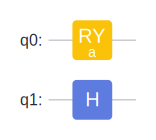

In [4]:
from mindquantum.core.circuit import Circuit   # 导入Circuit模块，用于搭建量子线路

circ = Circuit()                               #声明一个空的量子线路
circ += H.on(1)                                #向其中添加一个hadamard门，并作用到1号比特上
circ += RY('a').on(0)                          #向其中添加一个参数化的RY门，并作用到0号比特上
circ.svg()                                     #绘制SVG格式的量子线路图片

In [5]:
sim.apply_circuit(circ, pr={'a': 1.234})  #作用一个量子线路，当线路是一个参数化量子线路时，我们还需要提供参数值。
sim

mqvector simulator with 2 qubits (little endian), dtype: mindquantum.complex128.
Current quantum state:
0.11851349145283663¦00⟩
0.6971044056263442¦01⟩
0.11851349145283663¦10⟩
0.6971044056263442¦11⟩

在上面的代码中，我们先生成了一个参数化量子线路`circ`，随后我们将其作用到量子模拟器上，并通过传入字典的方式，将参数`a`设置为`1.234`。最后输出量子模拟器演化出来的量子态。

## 设置并获取模拟器状态

我们使用 [get_qs(ket=False)](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.get_qs) 查看当前模拟器的状态，
参数`ket`是一个`bool`类型的数，它决定了当前模拟器的状态是否以ket字符串的形式返回，`ket=False`时是以`numpy.ndarray`形式，`ket=True`时是以ket字符串形式。默认`ket=False`。

In [6]:
print(sim.get_qs())  #查看模拟器状态，以numpy.ndarray形式返回结果

[0.11851349+0.j 0.69710441+0.j 0.11851349+0.j 0.69710441+0.j]


In [7]:
print(sim.get_qs(True))  #查看模拟器状态，以ket形式返回结果

0.11851349145283663¦00⟩
0.6971044056263442¦01⟩
0.11851349145283663¦10⟩
0.6971044056263442¦11⟩


在实际写代码过程中，我们常常需要将模拟器指定一个初始态开始演化，这个操作可以使用 [set_qs()](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.set_qs) 实现。

例如，我们希望模拟器状态为

$$
\frac{\sqrt{3}}{3}|00⟩+\frac{\sqrt{6}}{3}|11⟩
$$

第一步：我们计算出目标状态的向量形式：

$$
\frac{\sqrt{3}}{3}|00⟩+\frac{\sqrt{6}}{3}|11⟩ =\frac{\sqrt{3}}{3}\times
\left(
\begin{array}{l}
1\\
0
\end{array}
\right)
\otimes
\left(
\begin{array}{l}
1\\
0
\end{array}
\right)+
\frac{\sqrt{6}}{3}\times
\left(
\begin{array}{l}
0\\
1
\end{array}
\right)\otimes
\left(
\begin{array}{l}
0\\
1
\end{array}
\right)= \frac{\sqrt{3}}{3}\times
\left(
\begin{array}{l}
1\\
0\\
0\\
0
\end{array}
\right)+
\frac{\sqrt{6}}{3}\times
\left(
\begin{array}{l}
0\\
0\\
0\\
1
\end{array}
\right)=
\left(
\begin{array}{l}
\frac{\sqrt{3}}{3}\\
0\\
0\\
\frac{\sqrt{6}}{3}
\end{array}
\right)
$$

第二步：我们将这个向量使用 [set_qs()](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.set_qs) 赋值给模拟器，让其作为模拟器的状态：

In [8]:
sim.set_qs(np.array([3**0.5, 0, 0, 6**0.5]))        #设置模拟器状态，无需归一化
print(sim.get_qs(True))                             #查看模拟器状态

0.5773502691896258¦00⟩
0.816496580927726¦11⟩


通过 [get_qs()](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.get_qs) 查看模拟器状态可以发现，当前模拟器状态即为我们希望设置的$\frac{\sqrt{3}}{3}|00⟩+\frac{\sqrt{6}}{3}|11⟩$。

在实际编程过程中，我们常常需要多次模拟电路，通过多开模拟器的方式会导致内存占用非常大，我们可以通过现有模拟器复位的方式来复用模拟器，从而减少内存消耗。

我们使用 [reset()](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.reset) 来复位模拟器：

In [9]:
sim.reset()          #复位模拟器
print(sim.get_qs())  #查看模拟器状态

[1.+0.j 0.+0.j 0.+0.j 0.+0.j]


可以发现，当前模拟器被复位成了初始的$1|00⟩$态，相当于一个全新的模拟器。

因此，我们可以根据自身所需的量子初态，设置对应的量子模拟器，并运行自定义的量子线路。赶紧动手运行你构造出的的第一个量子线路吧！

## [量子线路采样](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.sampling)

线路采样是指对量子线路执行多次模拟测量，统计测量出各种结果出现的频次。**采样不会改变量子线路中的状态**。

[sampling(circuit, pr=None, shots=1, seed=None)](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.sampling) 是`MindSpore Quantum`中提供的对模拟器进行线路采样方法，它接受四个参数：

- `circuit (Circuit)`：希望进行采样的[量子线路](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/core/circuit/mindquantum.core.circuit.Circuit.html)，注意，该线路中必须包含至少一个测量操作（即采样点）。
- `pr (Union[None, dict, ParameterResolver])`：[parameter resolver](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/core/parameterresolver/mindquantum.core.parameterresolver.ParameterResolver.html)，当 `circuit`是含参线路时，需要给出参数的值。
- `shots (int)`：采样的次数，默认为1。
- `seed`：采样时的随机种子，默认为一个随机数，可以不用提供。

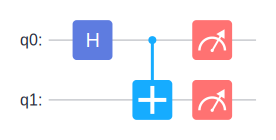

In [10]:
# 不含参线路采样：
from mindquantum.core.gates import Measure  # 引入测量门

circ = Circuit()                            # 初始化量子线路
circ += H.on(0)                             # H门作用在第0位量子比特
circ += X.on(1, 0)                          # X门作用在第1位量子比特且受第0位量子比特控制
circ += Measure('q0').on(0)                 # 在0号量子比特作用一个测量，并将该测量命名为'q0'
circ += Measure('q1').on(1)                 # 在1号量子比特作用一个测量，并将该测量命名为'q1'
circ.svg()                                  # 绘制SVG格式的量子线路图片

In [11]:
sim.reset()
result = sim.sampling(circ, shots=1000)  # 对上面定义的线路采样1000次
result

shots: 1000
Keys: q1 q0│0.00   0.127       0.254       0.381       0.508       0.635
───────────┼───────────┴───────────┴───────────┴───────────┴───────────┴
         00│▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
           │
         11│▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒
           │
{'00': 508, '11': 492}

MindSpore Quantum还提供了采样结果绘制SVG图的功能：

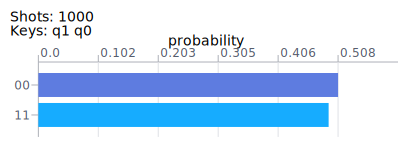

In [12]:
result.svg()  # 打印出测量结果的SVG格式

我们可以看到，采样1000中，'00'出现了508次，'11'出现了492次（在你运行时，结果可能会不同）。我们搭建的线路实际上制备出了一个贝尔态$\frac{\sqrt{2}}{2}|00⟩+\frac{\sqrt{2}}{2}|11⟩$。直观上，我们可以看到对该状态进行测量得到'00'的概率为$\frac{1}{2}$,得到'11'的概率为$\frac{1}{2}$，采样结果符合概率，细微的误差是由模拟器噪声导致。

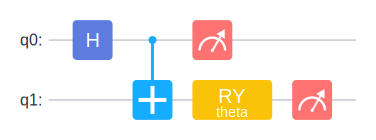

In [13]:
# 含参线路采样：
para_circ = Circuit()             # 初始化量子线路
para_circ += H.on(0)              # H门作用在第0位量子比特
para_circ += X.on(1, 0)           # X门作用在第1位量子比特且受第0位量子比特控制
para_circ += RY('theta').on(1)    # RY(theta)门作用在第1位量子比特
para_circ += Measure('q0').on(0)   # 在0号量子比特作用一个测量，并将该测量命名为'q0'
para_circ += Measure('q1').on(1)  # 在1号量子比特作用一个测量，并将该测量命名为'q1'
para_circ.svg()                   # 绘制SVG格式的量子线路图片

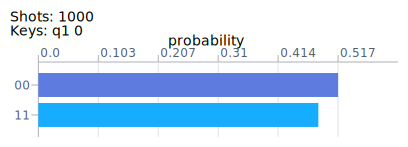

In [14]:
sim.reset()
result = sim.sampling(para_circ, {'theta': 0}, shots=1000)  # 将上面定义的线路参数'theta'赋值为0采样1000次
result.svg()

我们可以看到，采样结果中'00'出现了517次，'11'出现了483次（在你运行时，结果可能会不同）。事实上把RY门参数赋值为0，它即为我们熟悉的I门，相当于不对线路做任何操作，因此该采样线路与上面不含参线路本质是同一个，可以观察到二次采样结果几乎相同，符合预期结果。

## 模拟器支持情况

当前 MindSpore Quantum 支持多种模拟器，具体情况如下：

|模拟器名称|特性|是否支持GPU|单精度支持|多精度支持|
|--|--|--|--|--|
|`mqvector`|全振幅模拟器|❌|✅|✅|
|`mqvector_gpu`|GPU版全振幅模拟器|✅|✅|✅|
|`mqmatrix`|密度矩阵模拟器|❌|✅|✅|
|[NoiseBackend](https://mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.NoiseBackend.html#mindquantum.simulator.NoiseBackend)|噪声模拟器，教程请参考：[噪声模拟器](https://mindspore.cn/mindquantum/docs/zh-CN/r0.11/middle_level/noise_simulator.html)|✅|✅|✅|

> 请注意，`mqvector_gpu`后端仅支持在CUDA 11及以上版本的环境中运行。

## 模拟器的选择

我们知道，量子态的维度是随着比特数的增多而指数增加的，因此模拟大比特量子系统时，需要的物理内存将急剧增加。下面，我们给出不同比特下，存储一个全振幅量子态所需要的内存空间：

|比特数|mindquantum.complex128|mindquantum.complex64|
|--|--|--|
|6|1kB|0.5kB|
|16|1MB|0.5MB|
|26|1GB|0.5GB|
|30|16GB|8GB|
|36|1TB|0.5TB|
|40|16TB|8TB|
|46|1PB|0.5PB|

由此可见，在模拟大比特系统时，我们可以考虑使用单精度类型来减小内存占用量。在 MindSpore Quantum 中，我们可以通过 `dtype` 来方便的修改模拟器的数据类型：

In [15]:
import mindquantum as mq
from mindquantum.simulator import Simulator

sim = Simulator('mqvector', 2, dtype=mq.complex64)
print(sim)

mqvector simulator with 2 qubits (little endian), dtype: mindquantum.complex64.
Current quantum state:
1¦00⟩


下面我们给出一些经验规则，帮助大家来合理的选择不同的模拟器：

- 量子系统小于8比特时：`mqvector`。在小比特时，CPU反而会比GPU运行快速。
- 量子系统大于8比特时：`mqvector_gpu`。在大比特时，GPU将会发挥其并行运算优势。
- 混态模拟时：`mqmatrix`。`mqmatrix`是密度矩阵模拟器，因此支持混态系统的模拟。
- 量子系统含噪声时：[NoiseBackend](https://mindspore.cn/mindquantum/docs/zh-CN/r0.11/simulator/mindquantum.simulator.NoiseBackend.html#mindquantum.simulator.NoiseBackend)。通过该模拟器，我们可以方便的往线路中添加不同的量子信道，达到对噪声系统的模拟。
- 当进行量子化学模拟时：`mindquantum.complex128`。量子化学模拟需要模拟基态能量达到化学精度，因此建议用双精度类型。
- 当进行量子机器学习时：`mindquantum.complex64`。机器学习类任务对精度要求不敏感，因此建议用单精度类型。

想进一步学习如何对量子线路做测量操作，想了解采样结果分布的理论解释，请点击：[量子测量教程](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.11/beginner/quantum_measurement.html)。

In [16]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'scipy', 'numpy')